# Project C - Wavelets

In [28]:
import numpy as np
import numpy.fft as npf
import matplotlib
import matplotlib.pyplot as plt
import time
import imagetools.projectC as im

# Part 1 - Operators

# Q1 - Q3

See imagetools/projectC.py

Code is provided here for convenience

```
class Identity(LinearOperator):
    def __init__(self, shape):
        ishape = oshape = shape
        LinearOperator.__init__(self, ishape, oshape)
        
    def __call__(self, x):
        return x
    
    def adjoint(self, x):
        # note that the adjoint of the identity matrix is the identity matrix itself.
        # it is easy to see this by the definition of a linear operator, noting the commutative property of the inner product    
        return self.__call__(x)

    def gram(self, x):
        # apply the gram matrix to x, which is equivalent to just returning x
        return self.__call__(self.adjoint(x))
    
    def gram_resolvent(self, x, tau):
        # do the inversion by the conjugate gradient
        return cg(lambda z: z + tau * self.gram(z), x)
    
class Convolution(LinearOperator):
    def __init__(self, shape, nu, separable=None):
        ishape = oshape = shape
        LinearOperator.__init__(self, ishape, oshape)

        self._separable = separable
        n1, n2 = ishape[:2]
        self._nu_fft = kernel2fft(nu, n1, n2, separable=self._separable)
        # mu = F^{-1}(conjugate(F(nu))), see assignment 5 for explanation
        self._mu_fft = np.conjugate(self._nu_fft)
        
    def __call__(self, x):
        return convolvefft(x,self._nu_fft)
    
    def adjoint(self, x):
        return convolvefft(x, self._mu_fft)
    
    def gram(self, x):
        # self.adjoint(self.__call__(x),x), reduced to convolvefft(x, nu_fft*mu_fft) by properties of fft
        return convolvefft(x, nu_fft*mu_fft)
    
    def gram_resolvent(self, x, tau):
        # Assuming that boundary is always periodical
        # Just like the Gram LinearOperator, can do the inversion in the Fourier domain when periodical
        res_nu = 1 / (1 + tau * self._nu_fft * self._mu_fft)
        return convolvefft(x, res_nu)
    
class RandomMasking(LinearOperator):
    def __init__(self, shape, p):
        ishape = oshape = shape
        LinearOperator.__init__(self, ishape, oshape)
        
        self._apply_random_mask = np.random.choice(np.array([0,1]), size=oshape, p=[p,1-p])
        
    def __call__(self, x):
        # apply pixel by pixel the random mask
        return self._apply_random_mask * x
    
    def adjoint(self, x):
        # easy to see this is self-adjoint by the definition of a linear operator, noting the commutative property of the inner product 
        return self.__call__(x)

    def gram(self, x):
        # can also be reduced to self._apply_random_mask * x because 0*0=0, 1*0 =0, 0*1=0,1*1=1
        return self.__call__(self.adjoint(x))
    
    def gram_resolvent(self, x, tau):
        return cg(lambda z: z + tau * self.gram(z), x)
```

# Q4

In [29]:
starfish = plt.imread('assets/starfish.png')
x0 = starfish
motion_kernel = im.kernel('motion')

In [30]:
H_identity = im.Identity(x0.shape)
H_convolution = im.Convolution(x0.shape,nu=motion_kernel)
H_random_masking = im.RandomMasking(x0.shape,p=0.4)

In [31]:
y1, y2, y3 = H_identity(x0), H_convolution(x0), H_random_masking(x0)

images for Q4


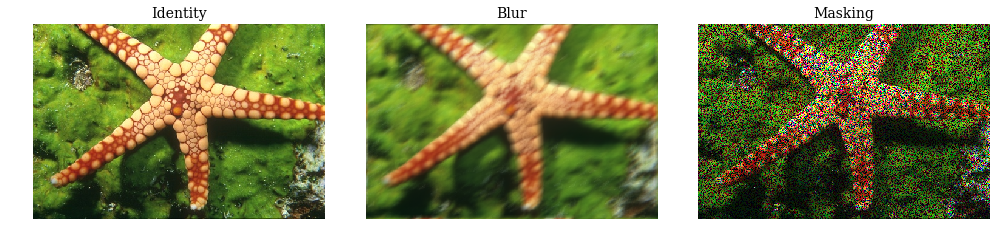

In [32]:
fig,ax = plt.subplots(1, 3,figsize=(14,6))
im.show(y1,ax=ax[0])
ax[0].tick_params(axis='both', which='major', labelsize=10)
ax[0].set_title('Identity',fontdict = {'fontsize' : 14})
im.show(y2,ax=ax[1])
ax[1].tick_params(axis='both', which='major', labelsize=10)
ax[1].set_title('Blur',fontdict = {'fontsize' : 14})
im.show(y3,ax=ax[2])
ax[2].tick_params(axis='both', which='major', labelsize=10)
ax[2].set_title('Masking',fontdict = {'fontsize' : 14})
print('images for Q4')

# Q5 assert that〈Hx, y〉=〈x,H∗y〉for any arbitrary arrays x and y of shape H.ishape and H.oshape respectively 

In [33]:
def dot_product(A,B):
    return np.sum(A*B)

def assert_adjoint(x,y,H):
    result = np.isclose(dot_product(H(x),y),dot_product(x,H.adjoint(y)))
    return result

In [34]:
def test_dotproduct_adjoint(totest):
    if totest is 'Identity':
        operator = im.Identity
    elif totest is 'Convolution':
        operator = im.Convolution
    elif totest is 'RandomMasking':
        operator = im.RandomMasking
    # earlier dims between 100 and 400
    a,b = np.random.randint(100,high=400,size=2)
    # later dims need to be 1 or 3 due to kernel2fft
    c,d = np.random.choice(np.array([1,3]), size=2, p=[.5,.5])
    # check for 1D
    if totest is 'Identity':
        H = operator(a)
    elif totest is 'RandomMasking':
        H = operator(a,p=0.2)
    if totest is not 'Convolution':
        x = np.random.rand(H.ishape)
        y = np.random.rand(H.oshape)
        print('1 dimensional case (int) - input shape is: ',x.shape, 'is does {} test'.format(totest),'hold? ',assert_adjoint(x,y,H))

    # check corner case for 1D
    if totest is 'Identity':
        H = operator((a,))
    elif totest is 'RandomMasking':
        H = operator((a,),p=0.2)
        
    if totest is not 'Convolution':
        x = np.random.rand(*H.ishape)
        y = np.random.rand(*H.oshape)
        print('1 dimensional case (tuple) - input shape is: ',x.shape, 'is does {} test'.format(totest),'hold? ',assert_adjoint(x,y,H))

    # check 2D
    if totest is 'Identity':
        H = operator((a,b))
    elif totest is 'Convolution':
        H = operator((a,b),nu=motion_kernel)
    elif totest is 'RandomMasking':
        H = operator((a,b),p=0.2)
    x = np.random.rand(*H.ishape)
    y = np.random.rand(*H.oshape)
    print('2 dimensional case - input shape is: ',x.shape, 'is does {} test'.format(totest),'hold? ',assert_adjoint(x,y,H))

    # check 3D
    if totest is 'Identity':
        H = operator((a,b,c))
    elif totest is 'Convolution':
        H = operator((a,b,c),nu=motion_kernel)
    elif totest is 'RandomMasking':
        H = operator((a,b,c),p=0.2)
    x = np.random.rand(*H.ishape)
    y = np.random.rand(*H.oshape)
    print(a,b,c)
    print('3 dimensional case - input shape is: ',x.shape, 'is does {} test'.format(totest),'hold? ',assert_adjoint(x,y,H))

    # check 4D
    if totest is 'Identity':
        H = operator((a,b,c,d))
    elif totest is 'Convolution':
        H = operator((a,b,c,d),nu=motion_kernel)
    elif totest is 'RandomMasking':
        H = operator((a,b,c,d),p=0.2)
    if totest is not 'Convolution':
        x = np.random.rand(*H.ishape)
        y = np.random.rand(*H.oshape)
        print('4 dimensional case - input shape is: ',x.shape, 'is does {} test'.format(totest),'hold? ',assert_adjoint(x,y,H))

    # after 4D we can assume it generalizes

# Test run 1

In [35]:
test_dotproduct_adjoint('Identity')

1 dimensional case (int) - input shape is:  (133,) is does Identity test hold?  True
1 dimensional case (tuple) - input shape is:  (133,) is does Identity test hold?  True
2 dimensional case - input shape is:  (133, 136) is does Identity test hold?  True
133 136 1
3 dimensional case - input shape is:  (133, 136, 1) is does Identity test hold?  True
4 dimensional case - input shape is:  (133, 136, 1, 3) is does Identity test hold?  True


In [36]:
test_dotproduct_adjoint('Convolution')

2 dimensional case - input shape is:  (245, 337) is does Convolution test hold?  True
245 337 3
3 dimensional case - input shape is:  (245, 337, 3) is does Convolution test hold?  True


In [37]:
test_dotproduct_adjoint('RandomMasking')

1 dimensional case (int) - input shape is:  (129,) is does RandomMasking test hold?  True
1 dimensional case (tuple) - input shape is:  (129,) is does RandomMasking test hold?  True
2 dimensional case - input shape is:  (129, 345) is does RandomMasking test hold?  True
129 345 3
3 dimensional case - input shape is:  (129, 345, 3) is does RandomMasking test hold?  True
4 dimensional case - input shape is:  (129, 345, 3, 1) is does RandomMasking test hold?  True


# Test run 2

In [38]:
test_dotproduct_adjoint('Identity')

1 dimensional case (int) - input shape is:  (311,) is does Identity test hold?  True
1 dimensional case (tuple) - input shape is:  (311,) is does Identity test hold?  True
2 dimensional case - input shape is:  (311, 374) is does Identity test hold?  True
311 374 3
3 dimensional case - input shape is:  (311, 374, 3) is does Identity test hold?  True
4 dimensional case - input shape is:  (311, 374, 3, 3) is does Identity test hold?  True


In [39]:
test_dotproduct_adjoint('Convolution')

2 dimensional case - input shape is:  (187, 252) is does Convolution test hold?  True
187 252 3
3 dimensional case - input shape is:  (187, 252, 3) is does Convolution test hold?  True


In [40]:
test_dotproduct_adjoint('RandomMasking')

1 dimensional case (int) - input shape is:  (121,) is does RandomMasking test hold?  True
1 dimensional case (tuple) - input shape is:  (121,) is does RandomMasking test hold?  True
2 dimensional case - input shape is:  (121, 218) is does RandomMasking test hold?  True
121 218 3
3 dimensional case - input shape is:  (121, 218, 3) is does RandomMasking test hold?  True
4 dimensional case - input shape is:  (121, 218, 3, 1) is does RandomMasking test hold?  True


# Test run 3

In [41]:
test_dotproduct_adjoint('Identity')

1 dimensional case (int) - input shape is:  (398,) is does Identity test hold?  True
1 dimensional case (tuple) - input shape is:  (398,) is does Identity test hold?  True
2 dimensional case - input shape is:  (398, 365) is does Identity test hold?  True
398 365 1
3 dimensional case - input shape is:  (398, 365, 1) is does Identity test hold?  True
4 dimensional case - input shape is:  (398, 365, 1, 1) is does Identity test hold?  True


In [42]:
test_dotproduct_adjoint('Convolution')

2 dimensional case - input shape is:  (262, 344) is does Convolution test hold?  True
262 344 3
3 dimensional case - input shape is:  (262, 344, 3) is does Convolution test hold?  True


In [43]:
test_dotproduct_adjoint('RandomMasking')

1 dimensional case (int) - input shape is:  (109,) is does RandomMasking test hold?  True
1 dimensional case (tuple) - input shape is:  (109,) is does RandomMasking test hold?  True
2 dimensional case - input shape is:  (109, 236) is does RandomMasking test hold?  True
109 236 1
3 dimensional case - input shape is:  (109, 236, 1) is does RandomMasking test hold?  True
4 dimensional case - input shape is:  (109, 236, 1, 3) is does RandomMasking test hold?  True


# Q6.  Check also that Inverse(Id +τH∗H) (x+τH∗Hx) = x for any arbitrary image x of shape H.ishape.

## Methodology to check: multiply both sides by  Inverse(x+τH∗Hx).
## lhs = H.gram_resolvent applied to x + tau * H.adjoint(H(x))
## rhs = x

In [44]:
def dot_product(A,B):
    return np.sum(A*B)

def assert_gram_resolvent_correct(H,x,tau):
    term = x + tau * H.adjoint(H(x))
    lhs = H.gram_resolvent(term,tau)
    rhs = x
    result = np.allclose(lhs,rhs)
    return result

In [45]:
def test_gram_resolvent(totest,tau):
    if totest is 'Identity':
        operator = im.Identity
    elif totest is 'Convolution':
        operator = im.Convolution
    elif totest is 'RandomMasking':
        operator = im.RandomMasking
    # earlier dims between 100 and 400
    a,b = np.random.randint(100,high=400,size=2)
    # later dims need to be 1 or 3 due to fft in the frequency domain
    c,d = np.random.choice(np.array([1,3]), size=2, p=[.5,.5])
    
    # check 2D
    if totest is 'Identity':
        H = operator((a,b))
    elif totest is 'Convolution':
        H = operator((a,b),nu=motion_kernel)
    elif totest is 'RandomMasking':
        H = operator((a,b),p=0.6)
    x = np.random.rand(*H.ishape)
    print('2 dimensional case - input shape is: ',x.shape, 'is does {} test'.format(totest),'hold? ',assert_gram_resolvent_correct(H,x,tau))

    # check 3D
    if totest is 'Identity':
        H = operator((a,b,c))
    elif totest is 'Convolution':
        H = operator((a,b,c),nu=motion_kernel)
    elif totest is 'RandomMasking':
        H = operator((a,b,c),p=0.6)
    x = np.random.rand(*H.ishape)
    print('3 dimensional case - input shape is: ',x.shape, 'is does {} test'.format(totest),'hold? ',assert_gram_resolvent_correct(H,x,tau))

    # check 4D
    if totest is 'Identity':
        H = operator((a,b,c,d))
    elif totest is 'Convolution':
        H = operator((a,b,c,d),nu=motion_kernel)
    elif totest is 'RandomMasking':
        H = operator((a,b,c,d),p=0.6)
    if totest is not 'Convolution':
        x = np.random.rand(*H.ishape)
        print('4 dimensional case - input shape is: ',x.shape, 'is does {} test'.format(totest),'hold? ',assert_gram_resolvent_correct(H,x,tau))

    # after 4D we can assume it generalizes

# Test run 1

In [46]:
test_gram_resolvent('Identity',tau=2)

2 dimensional case - input shape is:  (399, 130) is does Identity test hold?  True
3 dimensional case - input shape is:  (399, 130, 1) is does Identity test hold?  True
4 dimensional case - input shape is:  (399, 130, 1, 3) is does Identity test hold?  True


In [47]:
test_gram_resolvent('Convolution',tau=2)

2 dimensional case - input shape is:  (195, 181) is does Convolution test hold?  True
3 dimensional case - input shape is:  (195, 181, 1) is does Convolution test hold?  True


In [48]:
test_gram_resolvent('RandomMasking',tau=2)

2 dimensional case - input shape is:  (315, 209) is does RandomMasking test hold?  True
3 dimensional case - input shape is:  (315, 209, 1) is does RandomMasking test hold?  True
4 dimensional case - input shape is:  (315, 209, 1, 1) is does RandomMasking test hold?  True


# Test run 2

In [49]:
test_gram_resolvent('Identity',tau=2)

2 dimensional case - input shape is:  (277, 330) is does Identity test hold?  True
3 dimensional case - input shape is:  (277, 330, 3) is does Identity test hold?  True
4 dimensional case - input shape is:  (277, 330, 3, 1) is does Identity test hold?  True


In [50]:
test_gram_resolvent('Convolution',tau=2)

2 dimensional case - input shape is:  (394, 223) is does Convolution test hold?  True
3 dimensional case - input shape is:  (394, 223, 3) is does Convolution test hold?  True


In [51]:
test_gram_resolvent('RandomMasking',tau=2)

2 dimensional case - input shape is:  (294, 294) is does RandomMasking test hold?  True
3 dimensional case - input shape is:  (294, 294, 1) is does RandomMasking test hold?  True
4 dimensional case - input shape is:  (294, 294, 1, 3) is does RandomMasking test hold?  True


# Test run 3

In [52]:
test_gram_resolvent('Identity',tau=2)

2 dimensional case - input shape is:  (318, 279) is does Identity test hold?  True
3 dimensional case - input shape is:  (318, 279, 1) is does Identity test hold?  True
4 dimensional case - input shape is:  (318, 279, 1, 3) is does Identity test hold?  True


In [53]:
test_gram_resolvent('Convolution',tau=2)

2 dimensional case - input shape is:  (105, 255) is does Convolution test hold?  True
3 dimensional case - input shape is:  (105, 255, 1) is does Convolution test hold?  True


In [54]:
test_gram_resolvent('RandomMasking',tau=2)

2 dimensional case - input shape is:  (206, 130) is does RandomMasking test hold?  True
3 dimensional case - input shape is:  (206, 130, 1) is does RandomMasking test hold?  True
4 dimensional case - input shape is:  (206, 130, 1, 1) is does RandomMasking test hold?  True


# Part 4 - Wavelet Based Imaged Restoration

# Q22

In [3]:
def softthresh(z, t):
    new_z = (z - np.sign(z-t) * t) * np.maximum(np.abs(z)-t,0).astype(bool) # conversion to bool maps to (0,1)
    return new_z


# page 154/104 gives details on sparse regularization    
def sparse_analysis_regularization(y, sig, W, H=None, m=40, alpha=10/255,
                                   gamma=1, return_energy=False):
    if H is None:
        H_sparse = im.Identity(y.shape)
    else:
        H_sparse = H
            
    class ADMM:
        def __init__(self):
            # list_lambda contains list of lambda_i

            self.list_lambda = alpha * W.power() # see q13, list_lambda contains list of lambda_i
            self.Lambda = np.diag(np.reciprocal(self.list_lambda)) # (note capital) Lambda^(-1/2).
            self.m, self.n = y.size, W(x).size
            self.tau = np.sqrt(2*np.sqrt(self.m/self.n)) * sigma**2

            self._x = H_sparse.adjoint(y)
            self._z = W(self._x)
            self._dx , self._dz = 0 , 0

        def update(self, m):
            # update m times
            for i in range(m):
                x = H_sparse.gram_resolvent(self._x + self._dx + gamma * H_sparse.adjoint(y), tau=gamma)

                z = softthresh(self._z + self._dz, (gamma*tau) / self.list_lambda)
                self._x = W.gram_resolvent(x - self._dx + W.adjoint(z - self._dz), tau=1)
                self._z = W(self._x)
                self._dx = self._dx - x + self._x
                self._dz = self._dz - z + self._z

            return x

        def energy(self):
            left_term = np.sum((y - H(x))**2) / 2
            right_term = tau*np.sum(np.abs(np.self.Lambda.dot(W(x))))
            return left_term + right_term
    
    step = ADMM()
    x = step.update(m, return_energy)
            
    if return_energy:
        e = step.energy()
        return x, e
    else:
        return x

# Q23

In [4]:
# use psnr from assignment 4 for noise dB calculation
def psnr(x,x0):
    import math
    
    # if something is a bit over 1 or less than 0
    test_nlm = np.round(x)

    # used any for faster checking
    if not ((test_nlm>1).any() or (test_nlm<0).any()):
        Rsquared = 1
    elif not ((test_nlm>255).any() or (test_nlm<0).any()):
        Rsquared = 255
    else:
        raise TypeError('not an image')

    def l2normsquared(z):
        if len(z.shape)==3:
            temp = (z**2).mean(axis=2)
        else:
            temp = z**2
        
        return np.sum(temp)
    
    n = x.size
    
    return 10*math.log10((n*Rsquared) / l2normsquared(x-x0))

In [ ]:
x0 = plt.imread('assets/dragonfly.png')
sig = 20/255
y = x0 + sig * np.random.randn(*x0.shape)

W_dwt = im.DWT(y.shape, J=3, name='db2')
y_dwt = sparse_analysis_regularization(y, sig, W_dwt)

W_udwt = im.UDWT(y.shape, J=3, name='db2', using_fb=True)
y_udwt = sparse_analysis_regularization(y, sig, W_udwt)

For the above, maybe plot. Interpret the results.About how many iterations are required before the energy plateaus?

In [ ]:
y1 = softthresh_denoise(y,sig,W_dwt)
y2 = softthresh_denoise(y,sig,W_udwt)

In [ ]:
# plot as in q23
fig,ax = plt.subplots(2, 2,figsize=(14,6))
im.show(y,ax=ax[0,0])
ax[0,0].set_title('Noisy {} dB'.format(psnr(x0,y))),fontdict = {'fontsize' : 11})
im.show(y1,ax=ax[0,1])
ax[0,1].set_title('Softthresh DWT {} dB'.format(psnr(x0,y2)),fontdict = {'fontsize' : 11})
im.show(y2,ax=ax[1,0])
ax[1,0].set_title('Softthresh UDWT {} dB'.format(psnr(x0,y3)),fontdict = {'fontsize' : 11})
im.show(y_udwt,ax=ax[1,1])
ax[1,1].set_title('Sparse Analysis Regularization UDWT {} dB'.format(psnr(x0,y_udwt)),fontdict = {'fontsize' : 11})
print('images for Q4')

# Q24

In [ ]:
x0 = plt.imread('assets/topgun.png')
sig = 2/255
y = x0 + sig * np.random.randn(*x0.shape)
gamma = 100
H_conv = im.Convolution(x0.shape,nu=motion_kernel)

## Check the evolution of the loss by printing the energy / x after a number of iterations

In [ ]:
W_dwt = im.DWT(y.shape, J=3, name='db2')
y_dwt = sparse_analysis_regularization(y, sig, W_dwt,H=H_conv,m=10)

In [ ]:
y_dwt = sparse_analysis_regularization(y, sig, W_dwt,H=H_conv,m=20)

In [ ]:
y_dwt = sparse_analysis_regularization(y, sig, W_dwt,H=H_conv,m=30)

In [ ]:
y_dwt = sparse_analysis_regularization(y, sig, W_dwt,H=H_conv,m=40)

In [ ]:
W_udwt = im.UDWT(y.shape, J=3, name='db2', using_fb=True)
y_udwt = sparse_analysis_regularization(y, sig, W_udwt,H=H_conv,m=10)

In [ ]:
y_udwt = sparse_analysis_regularization(y, sig, W_udwt,H=H_conv,m=20)

In [ ]:
y_udwt = sparse_analysis_regularization(y, sig, W_udwt,H=H_conv,m=30)

In [ ]:
y_udwt = sparse_analysis_regularization(y, sig, W_udwt,H=H_conv,m=40)

## Plot results as in q24

In [ ]:
y1 = H_conv(y) # blur
y2 = y_dwt
y3 = y_udwt

fig,ax = plt.subplots(1, 3,figsize=(14,6))
im.show(y1,ax=ax[0])
ax[0].set_title('Blurry',fontdict = {'fontsize' : 14})
im.show(y2,ax=ax[1])
ax[1].set_title('SAR with DWT {} dB '.format(psnr(x0,y2)),fontdict = {'fontsize' : 14})
im.show(y3,ax=ax[2])
ax[2].set_title('SAR with UDWT {} dB '.format(psnr(x0,y3)),fontdict = {'fontsize' : 14})
print('images for Q4')